# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/larissa/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [4]:
# eth_vtol_param["gravity"] = 9.81; # set gravity

# Create Reinforcement Learning Environment

In [5]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
end

In [6]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x
            typemin(T)..typemax(T), # position error along z
            # TODO: more points?
            ], 
    )
    
    num_waypoints = 3 # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints) # trajectory with num_waypoints waypoints (+ start point) 
    reached_goal = falses(num_waypoints)
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints, 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        0.5 # r_tol
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [7]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[6]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[5]:2

# Define the RL interface

In [8]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [9]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    k_wp = 5.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate, TODO: change to gates later (when gates != waypoints)
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end
    
    k_ω = 0.01 # factor for too high body rate
    norm_ω = norm(env.ω_B[3]) # reward for body rate (penalty)

    k_s = 0.0 #5.0 # factor for reached distance (overall) reward, TODO later add factor as in paper (p. 4)
    r_s = env.progress # reward for reached distance (overall)
    
    
    
    k_p = 5.0 # factor for progress (between current position and last position) reward 
    r_p = env.progress - env.progress_prev # reward for progress (between current position and last position)

    return k_p * r_p + k_s * k_s + k_wp * r_wp - k_ω * norm_ω
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [10]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    env.num_waypoints = 3; # includig start point
    env.waypoints = generate_trajectory(env.num_waypoints);
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    env.r_tol = 0.5;
    
    if env.visualization
        visualize_waypoints(env.waypoints, 0.15); # debug: other radius?
    end
    

    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    norm_dir = 1# norm(env.waypoints[2] - env.x_W)
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 (env.waypoints[2][1] - env.x_W[1]) / norm_dir; # position error along x
                 (env.waypoints[2][3] - env.x_W[3]) / norm_dir] # position error along z
    
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;
    
    nothing

end;

In [11]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [12]:
env = VtolEnv();

In [13]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[11]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [14]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
        
        
        
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, progress = calculate_progress(env.waypoints, env.x_W)
    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - progress)
    
    env.progress = current_progress
    
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 
    env.t += env.Δt

    
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    
    if env.current_point <= env.num_waypoints
        norm_dir = 1 #norm(env.waypoints[env.current_point] - env.x_W)
        env.state[8] = (env.waypoints[env.current_point][1] - env.x_W[1]) / norm_dir; # position error along x
        env.state[9] = (env.waypoints[env.current_point][3] - env.x_W[3]) / norm_dir; # position error along z
    else
        env.state[8] = 0.0; # position error along x
        env.state[9] = 0.0; # position error along z
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast # TODO: set higher later in fast training phase
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 5.0 ||# stop after 5s per point
        norm(env.x_W - progress) > 2.0 || # too far off the path
        env.current_point > env.num_waypoints # all points reached
    nothing
end;

In [15]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.7s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.670350352711969e9, 1.67035035536765e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [16]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [17]:
# Define the function approximator
# TODO: change architecture eventually 
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [18]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [19]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_$t.bson") # TODO: evtl anpassen
    @save f model
    println("parameters at step $t saved to $f")
end;

In [20]:
function loadModel()
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_trained_on_random_point.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [21]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [22]:
agent.policy.approximator = loadModel(); # TODO: un/comment

In [23]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   1%|▎                                        |  ETA: 3:50:50

test reward at step 10000: 48.92600054824201


Progress:   1%|▌                                        |  ETA: 2:11:29

test reward at step 20000: 51.7232011925365


Progress:   2%|▊                                        |  ETA: 1:44:42

test reward at step 30000: 49.008092562083235


Progress:   3%|█▏                                       |  ETA: 1:29:15

test reward at step 40000: 63.23140930093604


Progress:   3%|█▍                                       |  ETA: 1:20:08

test reward at step 50000: 42.11727758292815


Progress:   4%|█▋                                       |  ETA: 1:12:24

test reward at step 60000: 67.64387464535923


Progress:   5%|█▉                                       |  ETA: 1:07:46

test reward at step 70000: 56.01234408385234


Progress:   5%|██▏                                      |  ETA: 1:03:43

test reward at step 80000: 48.22069184780675


Progress:   6%|██▍                                      |  ETA: 0:59:49

test reward at step 90000: 44.09782525545844


Progress:   7%|██▊                                      |  ETA: 0:56:39

parameters at step 100000 saved to ./RL_models_l/vtol_2D_ppo_100000.bson
test reward at step 100000: 48.0580761160821


Progress:   7%|███                                      |  ETA: 0:55:03

test reward at step 110000: 70.2346330970153


Progress:   8%|███▎                                     |  ETA: 0:52:58

test reward at step 120000: 73.64486463290638


Progress:   9%|███▌                                     |  ETA: 0:50:22

test reward at step 130000: 44.677857887741844


Progress:   9%|███▉                                     |  ETA: 0:48:39

test reward at step 140000: 71.01370222600521


Progress:  10%|████                                     |  ETA: 0:47:36

test reward at step 150000: 56.26017569769572


Progress:  11%|████▍                                    |  ETA: 0:45:43

test reward at step 160000: 53.54051892077932


Progress:  11%|████▋                                    |  ETA: 0:44:30

test reward at step 170000: 53.09382254701117


Progress:  12%|████▉                                    |  ETA: 0:43:34

test reward at step 180000: 77.60285580104869


Progress:  13%|█████▏                                   |  ETA: 0:42:28

test reward at step 190000: 61.102986172171896


Progress:  13%|█████▍                                   |  ETA: 0:41:43

parameters at step 200000 saved to ./RL_models_l/vtol_2D_ppo_200000.bson
test reward at step 200000: 53.22604704889958


Progress:  14%|█████▊                                   |  ETA: 0:40:33

test reward at step 210000: 62.979383043467855


Progress:  15%|██████                                   |  ETA: 0:39:44

test reward at step 220000: 55.32955228446561


Progress:  15%|██████▎                                  |  ETA: 0:39:08

test reward at step 230000: 63.64124854990081


Progress:  16%|██████▌                                  |  ETA: 0:38:14

test reward at step 240000: 57.62725321983762


Progress:  17%|██████▊                                  |  ETA: 0:37:27

test reward at step 250000: 67.44440471173115


Progress:  17%|███████▏                                 |  ETA: 0:36:37

test reward at step 260000: 65.43231477811877


Progress:  18%|███████▍                                 |  ETA: 0:36:02

test reward at step 270000: 61.02188669219684


Progress:  19%|███████▋                                 |  ETA: 0:35:21

test reward at step 280000: 48.13352588316063


Progress:  19%|███████▉                                 |  ETA: 0:34:44

test reward at step 290000: 48.80224089604383


Progress:  20%|████████▏                                |  ETA: 0:34:09

parameters at step 300000 saved to ./RL_models_l/vtol_2D_ppo_300000.bson
test reward at step 300000: 42.269105753373424


Progress:  21%|████████▌                                |  ETA: 0:33:35

test reward at step 310000: 59.276303813337876


Progress:  21%|████████▊                                |  ETA: 0:33:12

test reward at step 320000: 64.49802479472207


Progress:  22%|█████████                                |  ETA: 0:32:38

test reward at step 330000: 63.248028193878014


Progress:  23%|█████████▎                               |  ETA: 0:32:07

test reward at step 340000: 62.045859731390834


Progress:  23%|█████████▌                               |  ETA: 0:31:40

test reward at step 350000: 64.91235385542237


Progress:  24%|█████████▉                               |  ETA: 0:31:10

test reward at step 360000: 57.25047137631439


Progress:  25%|██████████▏                              |  ETA: 0:30:48

test reward at step 370000: 70.94958780023215


Progress:  25%|██████████▍                              |  ETA: 0:30:21

test reward at step 380000: 67.1469132712134


Progress:  26%|██████████▋                              |  ETA: 0:30:00

test reward at step 390000: 63.046805934876204


Progress:  27%|██████████▉                              |  ETA: 0:29:29

parameters at step 400000 saved to ./RL_models_l/vtol_2D_ppo_400000.bson
test reward at step 400000: 59.91268132020651


Progress:  27%|███████████▏                             |  ETA: 0:29:10

test reward at step 410000: 73.21404527635673


Progress:  28%|███████████▌                             |  ETA: 0:28:45

test reward at step 420000: 48.99750424338873


Progress:  29%|███████████▊                             |  ETA: 0:28:20

test reward at step 430000: 44.60817944657768


Progress:  29%|████████████                             |  ETA: 0:27:57

test reward at step 440000: 74.70420127319096


Progress:  30%|████████████▎                            |  ETA: 0:27:35

test reward at step 450000: 65.54701972857127


Progress:  31%|████████████▌                            |  ETA: 0:27:15

test reward at step 460000: 67.25205648448271


Progress:  31%|████████████▊                            |  ETA: 0:26:58

test reward at step 470000: 59.759322463730776


Progress:  32%|█████████████▏                           |  ETA: 0:26:36

test reward at step 480000: 51.83585606308736


Progress:  33%|█████████████▍                           |  ETA: 0:26:10

test reward at step 490000: 41.973378489230775


Progress:  33%|█████████████▋                           |  ETA: 0:25:47

parameters at step 500000 saved to ./RL_models_l/vtol_2D_ppo_500000.bson
test reward at step 500000: 60.078269331715205


Progress:  34%|█████████████▉                           |  ETA: 0:25:29

test reward at step 510000: 43.667192152885505


Progress:  35%|██████████████▎                          |  ETA: 0:25:09

test reward at step 520000: 69.78718203959505


Progress:  35%|██████████████▌                          |  ETA: 0:24:50

test reward at step 530000: 63.83010116773638


Progress:  36%|██████████████▊                          |  ETA: 0:24:30

test reward at step 540000: 57.39860730922856


Progress:  37%|███████████████                          |  ETA: 0:24:06

test reward at step 550000: 65.30413443908691


Progress:  37%|███████████████▎                         |  ETA: 0:23:48

test reward at step 560000: 50.01829954547022


Progress:  38%|███████████████▌                         |  ETA: 0:23:30

test reward at step 570000: 79.4167942537187


Progress:  39%|███████████████▉                         |  ETA: 0:23:12

test reward at step 580000: 60.08452721828997


Progress:  39%|████████████████▏                        |  ETA: 0:22:58

test reward at step 590000: 65.28742613003946


Progress:  40%|████████████████▍                        |  ETA: 0:22:37

parameters at step 600000 saved to ./RL_models_l/vtol_2D_ppo_600000.bson
test reward at step 600000: 59.24308658211132


Progress:  41%|████████████████▋                        |  ETA: 0:22:19

test reward at step 610000: 56.44254515160088


Progress:  41%|████████████████▉                        |  ETA: 0:22:03

test reward at step 620000: 65.92113529327919


Progress:  42%|█████████████████▏                       |  ETA: 0:21:48

test reward at step 630000: 72.20691624788554


Progress:  43%|█████████████████▌                       |  ETA: 0:21:28

test reward at step 640000: 48.45890535104811


Progress:  43%|█████████████████▊                       |  ETA: 0:21:10

test reward at step 650000: 41.50435297949541


Progress:  44%|██████████████████                       |  ETA: 0:20:51

test reward at step 660000: 60.43246463849311


Progress:  45%|██████████████████▎                      |  ETA: 0:20:34

test reward at step 670000: 36.99746705245463


Progress:  45%|██████████████████▋                      |  ETA: 0:20:18

test reward at step 680000: 60.259585551324754


Progress:  46%|██████████████████▉                      |  ETA: 0:20:02

test reward at step 690000: 59.2129896003894


Progress:  47%|███████████████████▏                     |  ETA: 0:19:45

parameters at step 700000 saved to ./RL_models_l/vtol_2D_ppo_700000.bson
test reward at step 700000: 42.412358695869244


Progress:  47%|███████████████████▍                     |  ETA: 0:19:28

test reward at step 710000: 51.975918891445374


Progress:  48%|███████████████████▋                     |  ETA: 0:19:11

test reward at step 720000: 52.056883967591254


Progress:  48%|███████████████████▊                     |  ETA: 0:19:10

LoadError: InterruptException:

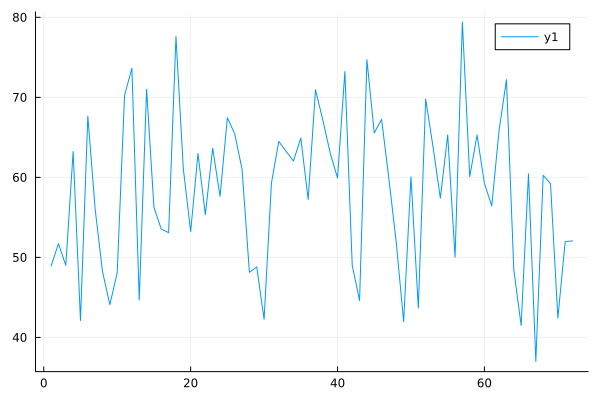

In [26]:
plot(episode_test_reward_hook.rewards)

In [27]:
close_visualization(); # closes the MeshCat visualization